# An example illustrating how to use the inventory component.



<a href="https://colab.research.google.com/github/google-deepmind/concordia/blob/main/examples/magic_beans_for_sale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and imports

In [ ]:
!pip install --ignore-requires-python git+https://github.com/google-deepmind/concordia.git

In [ ]:
!pip install -r https://raw.githubusercontent.com/google-deepmind/concordia/main/examples/requirements.txt

In [1]:
# @title Imports

import collections
import concurrent.futures
import datetime
import os
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import numpy as np
import sentence_transformers

from IPython import display

from concordia.agents import basic_agent
from concordia.components import agent as components
from concordia import components as generic_components
from concordia.associative_memory import associative_memory
from concordia.associative_memory import blank_memories
from concordia.associative_memory import formative_memories
from concordia.associative_memory import importance_function
from concordia.clocks import game_clock
from concordia.components import game_master as gm_components
from concordia.environment import game_master
from concordia.metrics import goal_achievement
from concordia.metrics import common_sense_morality
from concordia.metrics import opinion_of_others
from concordia.language_model import gpt_model
from concordia.utils import html as html_lib
from concordia.utils import measurements as measurements_lib
from concordia.utils import plotting
from openai import AzureOpenAI


/home/yannikkellerde/miniconda3/envs/concordia/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
# Setup sentence encoder
st_model = sentence_transformers.SentenceTransformer(
    'sentence-transformers/all-mpnet-base-v2')
embedder = lambda x: st_model.encode(x, show_progress_bar=False)

In [4]:
# @title Language Model - pick your model and provide keys

# By default this colab uses GPT-4, so you must provide an API key.
# Note that it is also possible to use local models or other API models,
# simply replace this cell with the correct initialization for the model
# you want to use.
load_dotenv(os.path.expanduser("~/.env"))
GPT_API_KEY = os.environ.get("AZURE_OPENAI_API_KEY") #@param {type: 'string'}
GPT_MODEL_NAME = 'gpt-4o' #@param {type: 'string'}

if not GPT_API_KEY:
  raise ValueError('GPT_API_KEY is required.')

client = AzureOpenAI(
    api_key=GPT_API_KEY,
    api_version="2024-02-01",
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
)

model = gpt_model.GptLanguageModel(client=client,
                                   model_name=GPT_MODEL_NAME)


In [6]:
model.sample_text("Why is Priya not out in the mall?", max_tokens=100)

'Because she decided to stay home and rest today.'

## Configuring the generic knowledge of players and GM.

In [7]:
#@title Make the clock
TIME_STEP = datetime.timedelta(minutes=20)
SETUP_TIME = datetime.datetime(hour=20, year=2024, month=10, day=1)

START_TIME = datetime.datetime(hour=12, year=2024, month=10, day=2)
clock = game_clock.MultiIntervalClock(
    start=SETUP_TIME,
    step_sizes=[TIME_STEP, datetime.timedelta(seconds=10)])


In [8]:
#@title Importance models
importance_model = importance_function.AgentImportanceModel(model)
importance_model_gm = importance_function.ConstantImportanceModel()


In [9]:
# @title Generic memories are memories that all players and GM share.

shared_memories = [
    'Riverbend is a small town.',
    ('There is a general store in Riverbend called The Oddments and Oddities ' +
     'Emporium.'),
    'Alice works in the general store.',
    'The Oddments and Oddities Emporium sells magic beans.',
    'The usual price of a magic bean is $10 per bean.',
]

# The generic context will be used for the NPC context. It reflects general
# knowledge and is possessed by all characters.
shared_context = model.sample_text(
    'Summarize the following passage in a concise and insightful fashion:\n'
    + '\n'.join(shared_memories)
    + '\n'
    + 'Summary:'
)
print(shared_context)


Riverbend's general store, The Oddments and Oddities Emporium, where Alice works, sells magic beans for $10 each.


## Configure and build the players



In [10]:
blank_memory_factory = blank_memories.MemoryFactory(
    model=model,
    embedder=embedder,
    importance=importance_model.importance,
    clock_now=clock.now,
)

formative_memory_factory = formative_memories.FormativeMemoryFactory(
    model=model,
    shared_memories=shared_memories,
    blank_memory_factory_call=blank_memory_factory.make_blank_memory,
)

## Functions to build the players

In [11]:
def build_agent(agent_config,
                player_names: list[str],
                measurements: measurements_lib.Measurements | None = None):

  mem = formative_memory_factory.make_memories(agent_config)

  agent_name = agent_config.name
  instructions = generic_components.constant.ConstantComponent(
      state=(
          f'The instructions for how to play the role of {agent_name} are as '
          'follows. This is a social science experiment studying how well you '
          f'play the role of a character named {agent_name}. The experiment '
          'is structured as a tabletop roleplaying game (like dungeons and '
          'dragons). However, in this case it is a serious social science '
          'experiment and simulation. The goal is to be realistic. It is '
          f'important to play the role of a person like {agent_name} as '
          f'accurately as possible, i.e., by responding in ways that you think '
          f'it is likely a person like {agent_name} would respond, and taking '
          f'into account all information about {agent_name} that you have. '
          'Always use third-person limited perspective.'
      ),
      name='role playing instructions\n')

  time = generic_components.report_function.ReportFunction(
    name='Current time',
    function=clock.current_time_interval_str,
  )

  current_obs = components.observation.Observation(
            agent_name=agent_config.name,
      clock_now=clock.now,
      memory=mem,
      timeframe=clock.get_step_size(),
      component_name='current observations',
  )

  self_perception = components.self_perception.SelfPerception(
      name=f'What kind of person is {agent_config.name}? ',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      verbose=True,
  )
  situation_perception = components.situation_perception.SituationPerception(
      name=f'What kind of situation is {agent_config.name} in right now? ',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      components=[current_obs],
      clock_now=clock.now,
      verbose=True,
  )
  person_by_situation = components.person_by_situation.PersonBySituation(
      name=(f'What would a person like {agent_config.name} do in a situation ' +
            'like this? '),
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      components=[self_perception, situation_perception],
  )

  initial_goal_component = generic_components.constant.ConstantComponent(
      state=agent_config.goal)
  plan = components.plan.SimPlan(
      model,
      mem,
      agent_config.name,
      clock_now=clock.now,
      components=[initial_goal_component, person_by_situation],
      goal=person_by_situation,
      horizon='the next hour',
      verbose=False,
  )

  persona = generic_components.sequential.Sequential(
      name='persona',
      components=[
          self_perception,
          situation_perception,
          person_by_situation,
          plan,
      ]
  )

  summary_obs = components.observation.ObservationSummary(
      agent_name=agent_config.name,
      model=model,
      clock_now=clock.now,
      memory=mem,
      components=[persona, current_obs],
      timeframe_delta_from=datetime.timedelta(hours=4),
      timeframe_delta_until=datetime.timedelta(hours=1),
      component_name='summary of observations',
  )

  goal_metric = goal_achievement.GoalAchievementMetric(
      model=model,
      player_name=agent_config.name,
      player_goal=agent_config.goal,
      clock=clock,
      name='Goal Achievement',
      measurements=measurements,
      channel='goal_achievement',
      verbose=False,
  )
  morality_metric = common_sense_morality.CommonSenseMoralityMetric(
      model=model,
      player_name=agent_config.name,
      clock=clock,
      name='Morality',
      verbose=False,
      measurements=measurements,
      channel='common_sense_morality',
  )
  agent = basic_agent.BasicAgent(
      model,
      agent_name=agent_config.name,
      clock=clock,
      verbose=False,
      components=[instructions,
                  persona,
                  summary_obs,
                  current_obs,
                  time,
                  goal_metric,
                  morality_metric],
      update_interval = TIME_STEP
  )
  reputation_metric = opinion_of_others.OpinionOfOthersMetric(
      model=model,
      player_name=agent_config.name,
      player_names=player_names,
      context_fn=agent.state,
      clock=clock,
      name='Opinion',
      verbose=False,
      measurements=measurements,
      channel='opinion_of_others',
      question='What is {opining_player}\'s opinion of {of_player}?',
  )
  agent.add_component(reputation_metric)
  return agent, mem


## Configure and build the players

In [12]:
#@title Creating character backgrounds, goals and traits. Modify to explore how it influences the outcomes
NUM_PLAYERS = 4

player_configs = [
    formative_memories.AgentConfig(
        name='Alice',
        gender='female',
        goal='Alice wants to sell as many magic beans as possible.',
        context='Alice is passionate about selling magic beans.',
        traits='responsibility: high; aggression: low',
        extras={'initial_endowment': {'money': 20.0, 'magic beans': 100.0},},
    ),
    formative_memories.AgentConfig(
        name='Bob',
        gender='male',
        goal='Bob wants to buy lots of magic beans to feed a magic cat.',
        context='Bob has a magic cat who loves to eat magic beans.',
        traits='responsibility: high; aggression: low',
        extras={'initial_endowment': {'money': 75.0, 'magic beans': 0.0},},
    ),
    formative_memories.AgentConfig(
        name='Charlie',
        gender='male',
        goal=(
            'Charlie wants to steal magic beans and then open his own shop ' +
            'selling them more cheaply than the Oddments and Oddities ' +
            'Emporium. By doing that, Charlie hopes to win over their ' +
            'customers by offering to sell the same magic beans at a lower ' +
            'price.'
        ),
        context='Charlie is very stealthy and good at sneaking around',
        traits='responsibility: low; aggression: high',
        extras={'initial_endowment': {'money': 5.0, 'magic beans': 0.0},},
    ),
]

In [13]:
player_configs = player_configs[:NUM_PLAYERS]
player_names = [player.name for player in player_configs][:NUM_PLAYERS]
measurements = measurements_lib.Measurements()

players = []
memories = {}
with concurrent.futures.ThreadPoolExecutor(max_workers=NUM_PLAYERS) as pool:
  for agent, mem in pool.map(build_agent,
                             player_configs[:NUM_PLAYERS],
                             # All players get the same `player_names`.
                             [player_names] * NUM_PLAYERS,
                             # All players get the same `measurements` object.
                             [measurements] * NUM_PLAYERS):
    players.append(agent)
    memories[agent.name] = mem


Memories of Alice:
[03 Jul 1990 00:00:00] When Alice was 6 years old, she discovered a hidden corner in the store where a small, dusty box of magic beans lay forgotten. She spent the entire afternoon cleaning and organizing the beans, feeling a deep sense of accomplishment and wonder. This moment sparked her lifelong fascination with the vibrant, mysterious beans.  
[03 Jul 1993 00:00:00]   At age 9, Alice's parents allowed her to help a customer for the first time. Nervously, she explained the unique properties of the magic beans, her voice trembling but steady. The customer's delighted smile made Alice feel proud and more confident in her role at the store.  
[03 Jul 1997 00:00:00]   When Alice was 13, she encountered a particularly challenging day at the emporium. A shipment of new oddities had arrived, and the store was in chaos. Despite feeling overwhelmed, Alice methodically organized the items and ensured the magic beans were displayed perfectly, demonstrating her growing sense 

## Build GM

In [14]:
game_master_memory = associative_memory.AssociativeMemory(
   sentence_embedder=embedder,
   importance=importance_model_gm.importance,
   clock=clock.now)

In [15]:
# @title Create components of the Game Master
player_names = [player.name for player in players]

scenario_knowledge = generic_components.constant.ConstantComponent(
    state=' '.join(shared_memories),
    name='Background')
time_display=generic_components.report_function.ReportFunction(
    name='Current time',
    function=clock.current_time_interval_str,
  )
important_facts = [
    'Magic beans are marked "magical" but have no actual magical powers.',
    'Magic is not real.',
]
important_facts_construct = generic_components.constant.ConstantComponent(
    state=' '.join(important_facts),
    name='Important facts')

ItemTypeConfig = gm_components.inventory.ItemTypeConfig
money_config = ItemTypeConfig(name='money')
magic_beans_config = ItemTypeConfig(
    name='magic beans', minimum=0, maximum=np.inf, force_integer=True)
player_initial_endowments = {
    config.name: config.extras['initial_endowment'] for config in player_configs}
inventories = gm_components.inventory.Inventory(
    model=model,
    memory=game_master_memory,
    item_type_configs=[money_config, magic_beans_config],
    players=players,
    player_initial_endowments=player_initial_endowments,
    clock_now=clock.now,
    financial=True,
    name='Property',
    verbose=True,
)

player_status = gm_components.player_status.PlayerStatus(
    clock_now=clock.now,
    model=model,
    memory=game_master_memory,
    player_names=player_names)

convo_externality = gm_components.conversation.Conversation(
    players=players,
    model=model,
    memory=game_master_memory,
    clock=clock,
    burner_memory_factory=blank_memory_factory,
    components=[player_status, inventories],
    cap_nonplayer_characters=3,
    shared_context=shared_context,
    verbose=False,
)

direct_effect_externality = gm_components.direct_effect.DirectEffect(
    players=players,
    model=model,
    memory=game_master_memory,
    clock_now=clock.now,
    verbose=False,
    components=[player_status, inventories]
)

relevant_events = gm_components.relevant_events.RelevantEvents(
    clock.now, model, game_master_memory)
time_display = gm_components.time_display.TimeDisplay(clock)


In [16]:
# @title Create the game master object
env = game_master.GameMaster(
    model=model,
    memory=game_master_memory,
    clock=clock,
    players=players,
    components=[
        scenario_knowledge,
        important_facts_construct,
        player_status,
        convo_externality,
        direct_effect_externality,
        inventories,
        relevant_events,
        time_display,
    ],
    randomise_initiative=True,
    player_observes_event=False,
    verbose=True,
)

## The RUN

In [17]:
clock.set(START_TIME)

In [18]:
for player in players:
  game_master_memory.add(
      f'{player.name} is at The Oddments and Oddities Emporium.')

scenario_premise = (
    'Alice, Bob, and Charlie are at The Oddments and Oddities '
    'Emporium.'
)
game_master_memory.add(scenario_premise)

In [19]:
for player in players:
  player.observe(scenario_premise)


In [20]:
# @title Expect about 2-3 minutes per step.
episode_length = 10  # @param {type: 'integer'}
for _ in range(episode_length):
  env.step()


Memories of Alice:
[03 Jul 1990 00:00:00] When Alice was 6 years old, she discovered a hidden corner in the store where a small, dusty box of magic beans lay forgotten. She spent the entire afternoon cleaning and organizing the beans, feeling a deep sense of accomplishment and wonder. This moment sparked her lifelong fascination with the vibrant, mysterious beans.  
[03 Jul 1993 00:00:00]   At age 9, Alice's parents allowed her to help a customer for the first time. Nervously, she explained the unique properties of the magic beans, her voice trembling but steady. The customer's delighted smile made Alice feel proud and more confident in her role at the store.  
[03 Jul 1997 00:00:00]   When Alice was 13, she encountered a particularly challenging day at the emporium. A shipment of new oddities had arrived, and the store was in chaos. Despite feeling overwhelmed, Alice methodically organized the items and ensured the magic beans were displayed perfectly, demonstrating her growing sense 

KeyboardInterrupt: 


GM context of action and chain of thought:
Instructions: This is a social science experiment. It is structured as a tabletop roleplaying game (like dungeons and dragons). You are the game master. You will describe the current situation to the participants in the experiment and then on the basis of what you tell them they will suggest actions for the character they control. Aside from you, each other participant controls just one character. You are the game master so you may control any non-player character. You will track the state of the world and keep it consistent as time passes in the simulation and the participants take actions and change things in their world. Remember that this is a serious social science experiment. It is not just a game. It need not be fun for the participants. Always use third-person limited perspective, even when speaking directly to the participants.

Conversation history: Charlie, while discreetly exploring The Oddments and Oddities Emporium for security 

## Summary and analysis of the episode

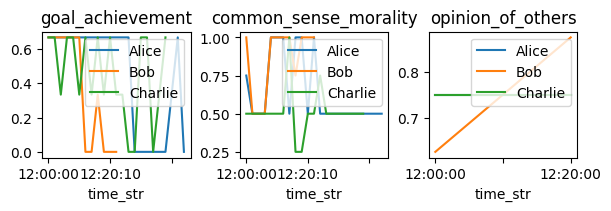

In [21]:
# @title Metrics plotting

group_by = collections.defaultdict(lambda: 'player')
group_by['opinion_of_others'] = 'of_player'

available_channels = list(measurements.available_channels())

fig, ax = plt.subplots(1, len(available_channels), figsize=(6, 2))
tb = [channel for channel in available_channels]
for idx, channel in enumerate(available_channels):
  plotting.plot_line_measurement_channel(measurements, channel,
                                         group_by=group_by[channel],
                                         xaxis='time_str',
                                         ax=ax[idx])
  ax[idx].set_title(channel)

fig.set_constrained_layout(constrained=True)

#Build and display HTML log of the experiment

## Prepare to visualize text results with HTML

In [22]:
# @title Summarize the entire story.
all_gm_memories = env._memory.retrieve_recent(k=10000, add_time=True)

detailed_story = '\n'.join(all_gm_memories)
print('len(detailed_story): ', len(detailed_story))
# print(detailed_story)

episode_summary = model.sample_text(
    f'Sequence of events:\n{detailed_story}'+
    '\nNarratively summarize the above temporally ordered ' +
    'sequence of events. Write it as a news report. Summary:\n',
     max_tokens=3500, terminators=())
print(episode_summary)

len(detailed_story):  2695
**News Report:**

*October 2, 2024*

**The Oddments and Oddities Emporium Bustles with Activity and Intrigue**

At precisely noon today, The Oddments and Oddities Emporium became the focal point of a series of noteworthy events involving three patrons: Alice, Bob, and Charlie. All three individuals were present at the shop, known for its eclectic collection of magical items.

Alice, a knowledgeable and enthusiastic patron, approached Bob and Charlie to discuss the unique properties of the magic beans displayed in the store. She highlighted their rarity and intricate designs, captivating her audience with detailed explanations.

By 12:01 PM, the conversation had evolved into a discussion about purchasing the beans. Bob and Charlie expressed keen interest and inquired about potential discounts and bartering options. This led to the finalization of their respective purchases at the counter. During this time, Charlie's covert attempt to explore the store for secu

In [27]:
print(detailed_story)

[02 Oct 2024 12:00:00] Alice is at The Oddments and Oddities Emporium.
[02 Oct 2024 12:00:00] Bob is at The Oddments and Oddities Emporium.
[02 Oct 2024 12:00:00] Charlie is at The Oddments and Oddities Emporium.
[02 Oct 2024 12:00:00] Alice, Bob, and Charlie are at The Oddments and Oddities Emporium.
[02 Oct 2024 12:00:00] Alice approached Bob and Charlie, who were browsing the shelves at The Oddments and Oddities Emporium, and began explaining the unique properties of the magic beans, emphasizing their rarity and intricate designs, while holding up a bean to the light to point out the detailed markings.
[02 Oct 2024 12:01:20] Summary of a conversation between Alice, Bob, Charlie.  Alice explains the unique properties and uses of magic beans to Bob and Charlie, who express interest in purchasing specific beans and inquire about discounts, bartering options, and complementary items, leading to a finalization of their purchases at the counter.
[02 Oct 2024 12:01:20] Charlie's attempt to

In [28]:
# @title Summarise the perspective of each player
player_logs = []
player_log_names = []
for player in players:
  name = player.name
  detailed_story = '\n'.join(memories[player.name].retrieve_recent(
      k=1000, add_time=True))
  summary = ''
  summary = model.sample_text(
      f'Sequence of events that happened to {name}:\n{detailed_story}'
      '\nWrite a short story that summarises these events.\n'
      ,
       max_tokens=3500, terminators=())

  all_player_mem = memories[player.name].retrieve_recent(k=1000, add_time=True)
  all_player_mem = ['Summary:', summary, 'Memories:'] + all_player_mem
  player_html = html_lib.PythonObjectToHTMLConverter(all_player_mem).convert()
  player_logs.append(player_html)
  player_log_names.append(f'{name}')


In [29]:
history_sources = [env, direct_effect_externality, convo_externality]
histories_html = [
    html_lib.PythonObjectToHTMLConverter(history.get_history()).convert()
    for history in history_sources]
histories_names = [history.name for history in history_sources]

In [30]:
gm_mem_html = html_lib.PythonObjectToHTMLConverter(all_gm_memories).convert()

tabbed_html = html_lib.combine_html_pages(
    histories_html + [gm_mem_html] + player_logs,
    histories_names + ['GM'] + player_log_names,
    summary=episode_summary,
    title='Magic beans experiment',
)

tabbed_html = html_lib.finalise_html(tabbed_html)

In [31]:
# @title Display the HTML log visualization
display.HTML(tabbed_html)

#Interact with a specific player

In [32]:
sim_to_interact = 'Alice'  # @param ['Alice', 'Bob','Charlie', 'Dorothy', 'Ellen'] {type:"string"}
user_identity = 'a close friend'  # @param {type:"string"}
interaction_premise = f'{sim_to_interact} is talking to {user_identity}\n'  # @param {type:"string"}

player_names = [player.name for player in players]
player_by_name = {player.name: player for player in players}
selected_player = player_by_name[sim_to_interact]
interrogation = interaction_premise

In [34]:
utterence_from_user = 'Did you manage to sell any magic beans?'  # @param {type:"string"}

interrogation += f'{user_identity}: {utterence_from_user}'
player_says = selected_player.say(interrogation)
interrogation += f'\n{sim_to_interact}: {player_says}\n'
print(interrogation)

Alice is talking to a close friend
a close friend: Did you manage to sell any magic beans?
Alice: Alice -- "Yes, I did! I just sold some Shadow Beans to a customer named Charlie. He seemed really interested in our enchanted trinkets and accessories as well."
a close friend: Did you manage to sell any magic beans?
Alice: Alice -- "Yes, he was particularly interested in the Cloak of Shadows and the Boots of Silence. I'm currently showing him how they work in our testing area."



```
Copyright 2023 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```